# 10 Regression Algorithms

1. **Linear Regression**: A simple regression model that assumes a linear relationship between the dependent and independent variables.

2. **Robust Regression**: A type of regression that is resistant to outliers, providing a more reliable model in the presence of data anomalies.

3. **Ridge Regression**: A linear regression model with L2 regularization that penalizes large coefficients to prevent overfitting.

4. **LASSO Regression**: A linear regression model with L1 regularization that performs feature selection by shrinking some coefficients to zero.

5. **Elastic Net**: A regression model that combines L1 and L2 regularization to balance feature selection and coefficient shrinkage.

6. **Polynomial Regression**: A regression model that extends linear regression by fitting a polynomial curve to capture non-linear relationships.

7. **Stochastic Gradient Descent**: An optimization algorithm that minimizes the cost function of a model by iteratively updating the model parameters with randomly selected samples.

8. **Artificial Neural Networks**: A computational model inspired by the human brain, consisting of layers of interconnected nodes (neurons) that can model complex relationships in data.

9. **Random Forest Regressor**: An ensemble learning method that uses multiple decision trees to improve predictive accuracy and control overfitting.

10. **Support Vector Machine**: A regression model that finds the best hyperplane to separate data points by maximizing the margin between support vectors, used for both linear and non-linear regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import yfinance as yf
import talib as ta
import seaborn as sns
import hvplot.pandas

%matplotlib inline

# The data contains the following columns:

1. **Volume**   
2. **10-day MA**  
3. **50-day MA**  
4. **200-day MA**

5. **RSI (Relative Strength Index)**: A momentum oscillator that measures the speed and change of price movements to identify overbought or oversold conditions.
    - Range: 0 to 100.
    - Overbought: RSI > 70 suggests the stock may be overbought (potentially due for a pullback).
    - Oversold: RSI < 30 suggests the stock may be oversold (potentially due for a rebound).
    
    
6. **MACD (Moving Average Convergence Divergence)**: A trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.
6.1. **MACD_signal** 
6.2. **MACD_hist** 

    - MACD Line: Difference between the 12-day EMA and 26-day EMA.
    - Signal Line: 9-day EMA of the MACD line.
    - Usage:
        - Bullish Signal: MACD line crosses above the Signal line.
        - Bearish Signal: MACD line crosses below the Signal line.


7. **Bollinger Bands**: Volatility bands placed above and below a moving average to identify overbought or oversold levels and gauge market volatility.
7.1. **Bollinger_upper**
7.2. **Bollinger_middle** 
7.3. **Bollinger_lower**  

    - Middle Band: 20-day Simple Moving Average (SMA).
    - Upper Band: 20-day SMA + 2 standard deviations.
    - Lower Band: 20-day SMA - 2 standard deviations.
    - Usage:
        - Overbought: Price near the upper band.
        - Oversold: Price near the lower band.
        - Volatility: Bands widen with higher volatility, contract with lower volatility.

8. **VIX**  
9. **Interest Rate**
10. **Daily Return**

In [2]:
seed = 123

ticker = 'AAPL'

today = datetime.today()
start_date = today - relativedelta(years=5)
end_date = today

# Fetch stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Technical Indicators
stock_data['10-day MA'] = stock_data['Close'].rolling(window=10).mean()
stock_data['50-day MA'] = stock_data['Close'].rolling(window=50).mean()
stock_data['200-day MA'] = stock_data['Close'].rolling(window=200).mean()
stock_data['RSI'] = ta.RSI(stock_data['Close'], timeperiod=14) # Relative Strength Index
stock_data['MACD'], stock_data['MACD_signal'], stock_data['MACD_hist'] = ta.MACD(stock_data['Close']) # Moving Average Convergence Divergence
stock_data['Bollinger_upper'], stock_data['Bollinger_middle'], stock_data['Bollinger_lower'] = ta.BBANDS(stock_data['Close'], timeperiod=20) # Bollinger Bands

# Market Sentiment - VIX Index (Volatility Index)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
vix_data = vix_data[['Close']].rename(columns={'Close': 'VIX'})

# Combine VIX with stock data
data = stock_data.join(vix_data)

# Fetch Citigroup 3-month T-bill rate:
citigroup_tbill = yf.download('^IRX', start=start_date, end=end_date)
data['Interest Rate'] = citigroup_tbill['Close']

# Calculate the daily return as the dependent variable
data['Daily Return'] = stock_data['Close'].pct_change()

# Remove the Open, High, Low, and Close columns
data = data.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close'])

# Drop the first row where Daily Return is NaN (because of pct_change())
data = data.dropna()

print(data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

               Volume  10-day MA  50-day MA  200-day MA        RSI      MACD  \
Date                                                                           
2020-06-17  114406400  85.136749   76.52940   69.203362  69.499022  3.068775   
2020-06-18   96820400  85.871999   76.99090   69.385900  69.563665  3.096985   
2020-06-19  264476000  86.327499   77.40915   69.561562  67.356688  3.043709   
2020-06-22  135445200  86.962749   77.86355   69.743550  71.750430  3.149760   
2020-06-23  212155600  87.526249   78.32995   69.935137  74.807495  3.349718   

            MACD_signal  MACD_hist  Bollinger_upper  Bollinger_middle  \
Date                                                                    
2020-06-17     2.812139   0.256636        88.820051         82.522250   
2020-06-18     2.869108   0.227877        89.515027         82.928500   
2020-06-19     2.904028   0.139681        89.972477         83.339375   
2020-06-22     2.953175   0.196586        90.804667         83.839124   
2

In [3]:
data.columns

Index(['Volume', '10-day MA', '50-day MA', '200-day MA', 'RSI', 'MACD',
       'MACD_signal', 'MACD_hist', 'Bollinger_upper', 'Bollinger_middle',
       'Bollinger_lower', 'VIX', 'Interest Rate', 'Daily Return'],
      dtype='object')

# Exploratory Data Analysis (EDA)

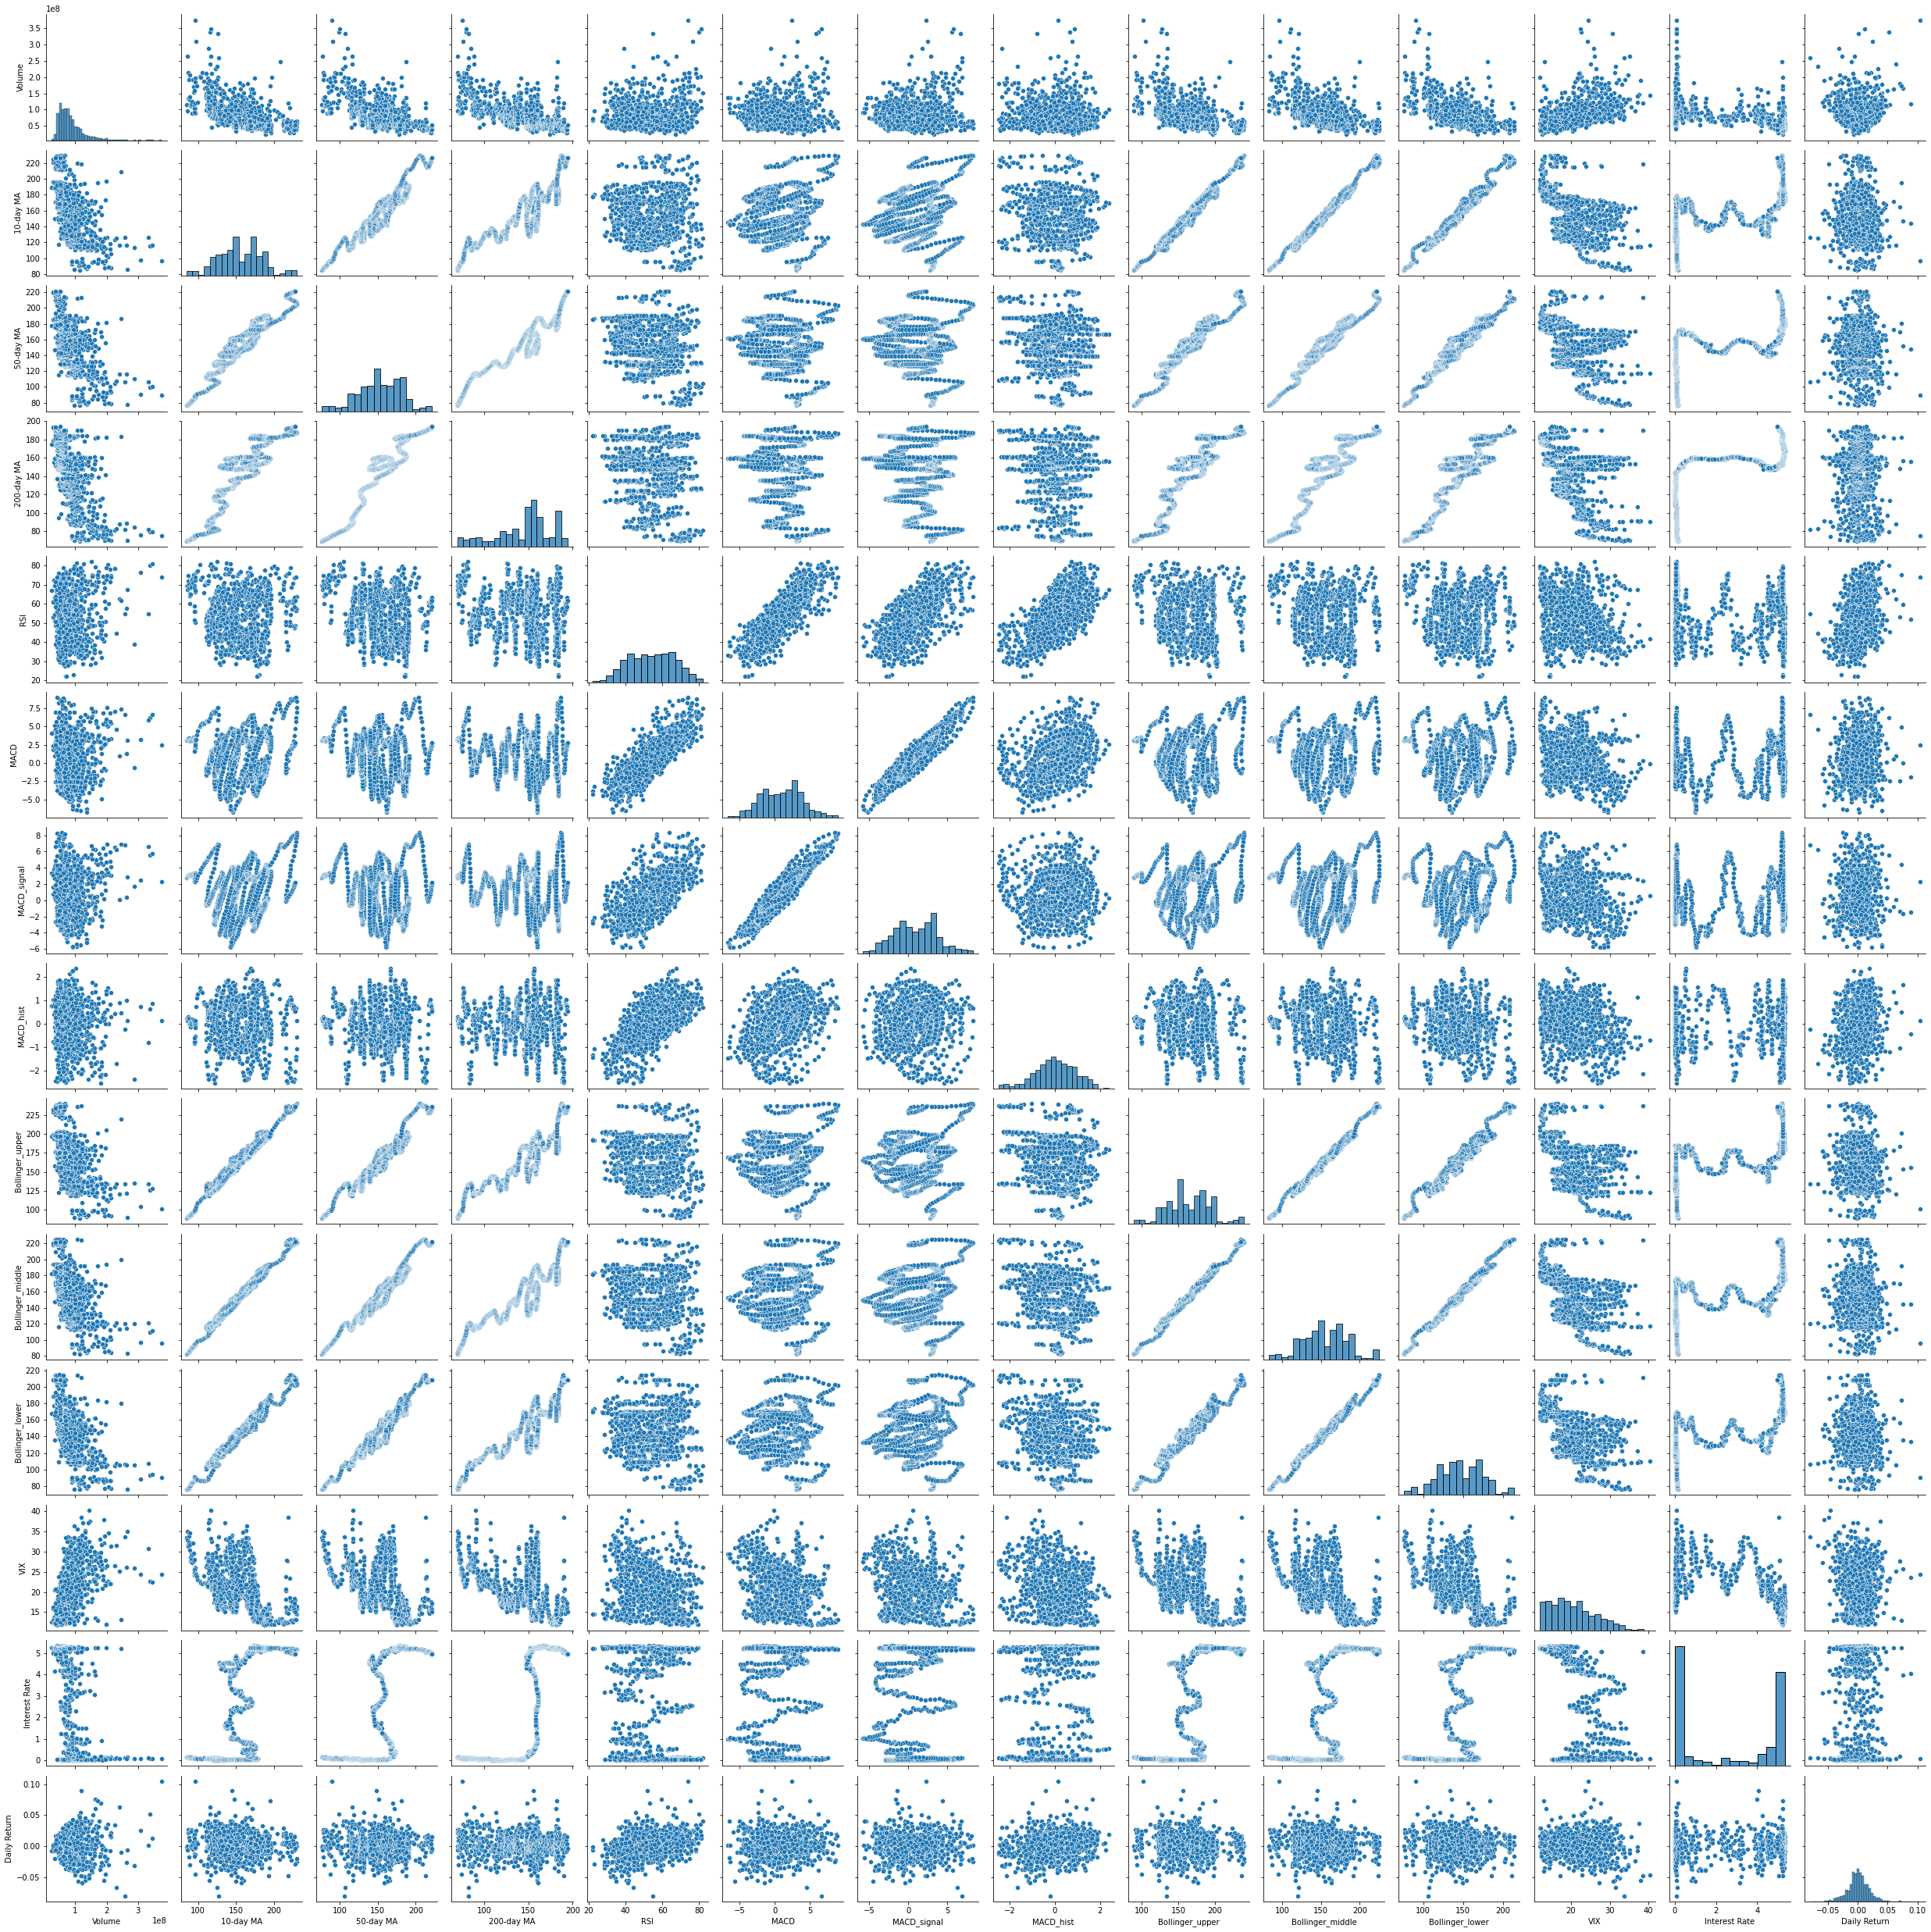

In [4]:
sns.pairplot(data)

In [5]:
data.hvplot.hist("Daily Return")

:Histogram   [Daily Return]   (Daily Return_count)

<AxesSubplot:>

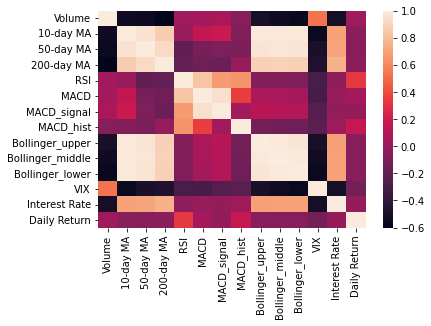

In [6]:
sns.heatmap(data.corr())

# Training a Linear Regression Model

In [7]:
X = data.drop(columns = 'Daily Return')
y = data['Daily Return']

In [8]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [9]:
# from sklearn.model_selection import TimeSeriesSplit

# cv=10 = 10-fold cross-validation: the data will be split into 10 parts, with the model being trained on 9 parts and tested on the remaining 1 part.
# This process is repeated 10 times, each time with a different part as the test set.
cv = TimeSeriesSplit(n_splits = 10)
cv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [10]:
# from sklearn import metrics
# from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=cv)
    # For Regression Models: The default scoring is R².
    # For Classification Models: The default scoring is accuracy.
    return pred.mean()
    # Returns: The function calculates the cross-validation scores and returns the mean score across all folds.

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted) # It penalizes larger errors more heavily than MAE
    rmse = np.sqrt(mse)
    r2_square = metrics.r2_score(true, predicted) #  R² represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# Preparing Data

In [11]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# 1.  Linear Regression

In [12]:
# from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

### Model Evaluation

In [13]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

0.0012643548091773181


,Coefficient
Volume,0.001061
10-day MA,0.052355
50-day MA,-0.024258
200-day MA,0.000037
RSI,0.024033
MACD,-0.014751
MACD_signal,-0.012315
MACD_hist,-0.010144
Bollinger_upper,0.000245
Bollinger_middle,-0.009171


### Predictions from the Model

In [14]:
pred = lin_reg.predict(X_test)

In [15]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [16]:
pd.DataFrame({'Error Values': (y_test - pred)}).hvplot.kde()

:Distribution   [Error Values]   (Density)

### Regression Evaluation Metrics

In [17]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 0.011247835268238587
MSE: 0.00023552216517451233
RMSE: 0.015346731416640884
R2 Square 0.42787134844026964
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.010635505589540583
MSE: 0.00020007694346783054
RMSE: 0.014144855724532172
R2 Square 0.3337281961105496
__________________________________


# 2. Robust Regression

In [18]:
# from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.014146369621699729
MSE: 0.0004229398671003937
RMSE: 0.0205655018684299
R2 Square -0.027402307021530126
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.01307529080551414
MSE: 0.0003631211549001012
RMSE: 0.019055738109559052
R2 Square -0.20922172596369637
__________________________________


# 3. Ridge Regression

In [19]:
# from sklearn.linear_model import Ridge

model = Ridge(alpha=0.2, solver='cholesky', tol=0.0001, random_state=seed)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.011257789754826265
MSE: 0.00023615652052024687
RMSE: 0.015367384960371327
R2 Square 0.42633037726120504
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.010647615844065504
MSE: 0.00020030654998102443
RMSE: 0.014152969652374177
R2 Square 0.33296358853968744
__________________________________


/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.19959e-18): result may not be accurate.
  overwrite_a=True).T
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.59093e-18): result may not be accurate.
  overwrite_a=True).T
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.19323e-18): result may not be accurate.
  overwrite_a=True).T
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00466e-18): result may not be accurate.
  overwrite_a=True).T
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.44352e-19): result may not be accurate.
  overwrite_

# 4. LASSO Regression

In [20]:
# from sklearn.linear_model import Lasso

model = Lasso(alpha=0, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=seed)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.01365635102424907
MSE: 0.0003608628803679218
RMSE: 0.018996391245916205
R2 Square 0.12339463680676954
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.012518016226382905
MSE: 0.00026981674730886234
RMSE: 0.016426099576858238
R2 Square 0.10148921793197863
__________________________________


/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09996710487793346, tolerance: 2.2251731837396142e-05
  tol, rng, random, positive)


# 5. Elastic Net

In [21]:
# from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.2, l1_ratio=0, selection='random', random_state=seed)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

/Users/claudia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09469635147072603, tolerance: 2.2251731837396142e-05
  positive)


Test set evaluation:
_____________________________________
MAE: 0.012878829565259462
MSE: 0.0003141312607219242
RMSE: 0.01772374849522313
R2 Square 0.23691473167111565
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.011538211977104655
MSE: 0.00023710386395394724
RMSE: 0.0153981772932366
R2 Square 0.21042566720759892
__________________________________


# 6. Polynomial Regression

In [22]:
# from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.010179111193206077
MSE: 0.0001867343319921877
RMSE: 0.013665077094264332
R2 Square 0.5463863815813845
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.008569792102123299
MSE: 0.00012669038441691493
RMSE: 0.011255682316808471
R2 Square 0.5781111531500491
__________________________________


# 7. Stochastic Gradient Descent

In [23]:
# from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.013711259641033487
MSE: 0.0003573930764873199
RMSE: 0.018904842672905795
R2 Square 0.13182345799187767
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.012185414190213267
MSE: 0.0002630887556893011
RMSE: 0.01622001096452469
R2 Square 0.12389395400612269
__________________________________


# 8. Artficial Neural Network

In [24]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Activation, Dropout
# from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

Epoch 1/100
741/741 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 5.7460e-04
Epoch 2/100
741/741 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 5.8354e-04
Epoch 3/100
741/741 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 5.1393e-04
Epoch 4/100
741/741 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 4.5981e-04
Epoch 5/100
741/741 [==============================] - 1s 1ms/step - loss: 9.2205e-04 - val_loss: 5.0024e-04
Epoch 6/100
741/741 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 4.3327e-04
Epoch 7/100
741/741 [==============================] - 1s 2ms/step - loss: 8.3407e-04 - val_loss: 4.5243e-04
Epoch 8/100
741/741 [==============================] - 1s 1ms/step - loss: 8.3784e-04 - val_loss: 4.6178e-04
Epoch 9/100
741/741 [==============================] - 1s 1ms/step - loss: 8.5924e-04 - val_loss: 4.0824e-04
Epoch 10/100
741/741 [=================

In [25]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [26]:
pd.DataFrame(r.history).hvplot.line(y=['loss', 'val_loss'])

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [27]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Artficial Neural Network", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.01388818041782778
MSE: 0.00036588695601872496
RMSE: 0.01912817178976404
R2 Square 0.111190190463903
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.007406201992749317
MSE: 9.491498888625333e-05
RMSE: 0.009742432390643176
R2 Square 0.6839256949586543
__________________________________


# 9. Random Forest Regressor

In [28]:
# from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.012640536153751422
MSE: 0.0002910835271667192
RMSE: 0.017061170158190184
R2 Square 0.2929021106537981
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.004171447886322974
MSE: 3.121849198925082e-05
RMSE: 0.0055873510708788305
R2 Square 0.8960399903563558
__________________________________


# 10. Support Vector Machine

In [29]:
# from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf', C=1000000, epsilon=0.001)
svm_reg.fit(X_train, y_train)

test_pred = svm_reg.predict(X_test)
train_pred = svm_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["SVM Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.02528704812289607
MSE: 0.0015826106956764276
RMSE: 0.039782039863189865
R2 Square -2.8444658598924426
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.0010194438919806988
MSE: 1.1715868142282542e-06
RMSE: 0.0010823986392398386
R2 Square 0.996098524664565
__________________________________


In [30]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.011248,0.000236,0.015347,0.427871,-9.338692
1,Robust Regression,0.014146,0.000423,0.020566,-0.027402,-21.672179
2,Ridge Regression,0.011258,0.000236,0.015367,0.426330,-6.415229
3,Lasso Regression,0.013656,0.000361,0.018996,0.123395,-0.014928
4,Elastic Net Regression,0.012879,0.000314,0.017724,0.236915,-0.014928
5,Polynomial Regression,0.010179,0.000187,0.013665,0.546386,0.000000
6,Stochastic Gradient Descent,0.013711,0.000357,0.018905,0.131823,0.000000
7,Artficial Neural Network,0.013888,0.000366,0.019128,0.111190,0.000000
8,Random Forest Regressor,0.012641,0.000291,0.017061,0.292902,0.000000
9,SVM Regressor,0.025287,0.001583,0.039782,-2.844466,0.000000


# Models Comparison

<AxesSubplot:ylabel='Model'>

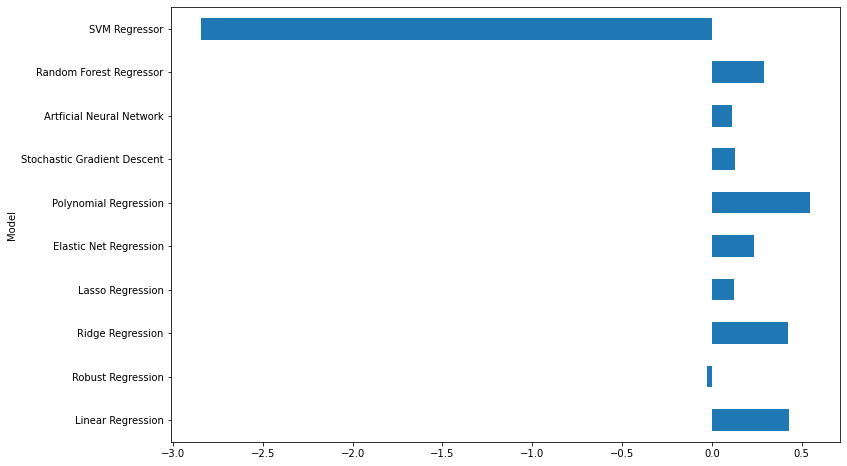

In [31]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))